<img src="https://k48b9e9840-flywheel.netdna-ssl.com/wp-content/uploads/2021/07/alfons-morales-YLSwjSy7stw-unsplash.jpg">

<a id="section-one"></a>
# Introduction

As an avid reader, I am constantly looking for book recommendations - whether it be from friends, colleagues, book store employees, or the internet.  Besides some obscurely good books found by happenchance, good ratings and reviews drive those recommendations.  Although, it is from the easiest thing to recommend a good book.  A book is dynamic, dense, and can have so much potential to ruin the palette of the reader in just one sentence.  So the question that started my analysis was how do you recommend a good book using data?

During this analysis, I am analyzing the data findings of popular books, authors, and who is reading/rating these books.  The data mimicks what would come from the app Good Reads.  Good Reads is Amazon's book tracker and rater for all types of readers.  It uses data to suggest new books to readers, but primarily acts as a data warehouse for all books so the user can create their own personalized data warehouse of books.  This way users can keep track of what they have read, want to read, and are currently reading.  We will look at multiple ways that our data can recommend books.

<a id="section-two"></a>
# Data

The three data sets being used for the analysis are a list of books - including ISBN, author, title, and year published; a list of books that have been rated - including ISBN, book rating, and user id who rated the book; and finally, the list of users who are rating the books using the application - including their location, age, and user id.  The files are csv type.  We are not planning to alter the initially existing data; instead, only edit current copies of the data.

### Data Dictionary

| Field | Description |
| :-- | :-- |
| **User-ID** | Book reader's unique user ID
| **ISBN** | ISBN of book
| **Book Rating** | Book rating by individual user 
| **Book Title** | Book title
| **Book Author** | Book author
| **Publication Year** | Year book was published
| **Publisher** | Book publisher
| **Age** | Age of user
| **City** | City where user is from
| **State** | State where user is from
| **Country** | Country where user is from
| **Average Rating** | Overall average rating of book title
| **Frequency** | Frequency that book title appears
| **Author Frequency** | Frequency that author appears
| **Book Read by Age Frequency** | Book frequency based on age of users
| **Book Read by Country Frequency** | Book frequency based on country of users

<a id="subsection-one"></a>
## Assumptions

The initial reviews of the data shows some missing pieces.  Therefore, I made some assumptions about the data:
  - First, I removed any Book Ratings = 0.  As a user of the Good Reads app, I know that that you cannot give a 0 rating.  Therefore, we are assuming they are unrated entries.
  - Second, I removed any books that had a Publishing Year of 0.  I made the assumption that this is an improperly created entry and there could be other data problems with the entry.
  - Third, I took any user with an age of 0 or over 100 and created an average age excluding those users.  I then mapped those users' ages with the average age.  I made the assumption that those users either didn't fill in their data properly or made a typo.

Since our beginning sample size is so large, the missing data we presume will not drastically affect the end results.  The data we are primarily looking at is the frequency of a Book Title being rated and the average rating it received.  I wanted to have as much data integrity when it came to the users and the book logs that are being used to make these calculations.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

book_ratings = pd.read_csv("/kaggle/input/bookcrossing-dataset/Book reviews/Book reviews/BX-Book-Ratings.csv", sep=";", encoding='CP1252', escapechar='\\')
books = pd.read_csv("/kaggle/input/bookcrossing-dataset/Book reviews/Book reviews/BX_Books.csv", sep=";", encoding='CP1252', escapechar='\\')
users = pd.read_csv("/kaggle/input/bookcrossing-dataset/Book reviews/Book reviews/BX-Users.csv", sep=";", encoding='CP1252', escapechar='\\')

<a id="subsection-one"></a>
## Data Clean Up

This is the beginning of our data clean up.  Below I am limiting the users data based off of age, and breaking up the users data from a location column to City, State, and Country for analaysis.

In [2]:
fix_users_age = users[users.Age > 0]
fix_users_age = users[users.Age < 100]
users['Age'].fillna(fix_users_age['Age'].mean())
users = users[users.Age < 100]
users = users[users.Age > 4]
location = users.Location.str.split(', ', expand=True)
users['City'] = location[0].str.title()
users['State'] = location[1].str.title()
users['Country'] = location[2].str.title()

In [3]:
print(f" As we can see the average age of user is {fix_users_age['Age'].mean():.2f}")

 As we can see the average age of user is 34.57


Next in the data clean up, I am removing any duplicates from the Book Ratings database so that each row is distinct.  The ratings should then be properly calculated and uneffected by duplicate data.  Next the tables are combined using an inner join to leave only the books that have ratings and users corresponding with them.  I am also cleaning up the columns by dropping columns we will no longer need for analysis and renaming the other columns for clarity while reading.  Below is a sample of the data.

In [4]:
book_ratings_removed_duplicates = book_ratings.drop_duplicates()
fix_book_ratings = book_ratings_removed_duplicates[book_ratings_removed_duplicates['Book-Rating'] > 0]
books = books[books['Year-Of-Publication'] > 0]
books = books[books['Year-Of-Publication'] < 2021]

books_with_reviews_and_users = pd.merge(fix_book_ratings,books, how = 'inner').merge(users, how = 'inner')
books_with_reviews_and_users = books_with_reviews_and_users.drop_duplicates()
books_with_reviews_and_users = books_with_reviews_and_users.drop(columns = ['Image-URL-S', 'Image-URL-M', 'Image-URL-L', 'Location'])
books_with_reviews_and_users = books_with_reviews_and_users.rename(columns={"User-ID": "User ID", "Book-Rating": "Book Rating", "Book-Author": "Book Author", "Book-Title": "Book Title","Year-Of-Publication": "Publication Year"})
books_with_reviews_and_users['Book Author'] = books_with_reviews_and_users['Book Author'].str.title()

avg_rating = books_with_reviews_and_users.groupby(['Book Title'])['Book Rating'].mean()
avg_rating = avg_rating.reset_index().rename(columns = {'Book Rating': 'Average Rating'})
books_with_reviews_and_users = books_with_reviews_and_users.merge(avg_rating, on = 'Book Title')
books_with_reviews_and_users = books_with_reviews_and_users[books_with_reviews_and_users['Book Title'] != 'Wild Animus']

books_with_reviews_and_users.head(10)

,User ID,ISBN,Book Rating,Book Title,Book Author,Publication Year,Publisher,Age,City,State,Country,Average Rating
0,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,16.0,Rijeka,N/A,Croatia,3.000000
1,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,16.0,Rijeka,N/A,Croatia,6.000000
2,16877,038550120X,9,A Painted House,John Grisham,2001,Doubleday,37.0,Houston,Arkansas,Usa,7.608696
3,21340,038550120X,9,A Painted House,John Grisham,2001,Doubleday,45.0,Holton,Kansas,Usa,7.608696
4,21356,038550120X,7,A Painted House,John Grisham,2001,Doubleday,56.0,Westwood,New Jersey,Usa,7.608696
5,22625,038550120X,10,A Painted House,John Grisham,2001,Doubleday,54.0,Lynbrook,New York,Usa,7.608696
6,31315,038550120X,6,A Painted House,John Grisham,2001,Doubleday,34.0,Henryville,Indiana,Usa,7.608696
7,32188,038550120X,8,A Painted House,John Grisham,2001,Doubleday,51.0,St. Louis,Missouri,Usa,7.608696
8,33974,038550120X,8,A Painted House,John Grisham,2001,Doubleday,24.0,Barnhart,Missouri,Usa,7.608696
9,37800,038550120X,9,A Painted House,John Grisham,2001,Doubleday,63.0,Rackerby,California,Usa,7.608696


As we can see in the histogram below, the data in our new final dataframe is clean and doing exactly what we want.  We are limiting our data.  We primarily have people from the ages of 25 to 45 who are providing us with the most reviews, which reiterates what was found before that the average age was 35.74.  We can assume that this would be that target audience for the GoodReads app, as well as, publishers.

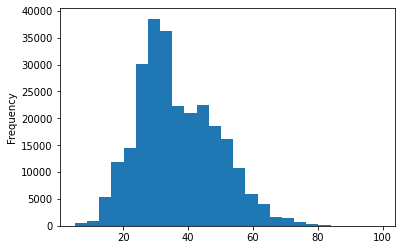

In [5]:
books_with_reviews_and_users['Age'].plot(kind='hist', bins=25);

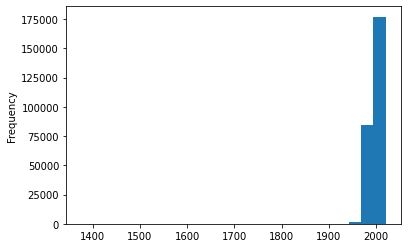

In [6]:
books_with_reviews_and_users['Publication Year'].plot(kind='hist', bins=25);

In [7]:
print(f"The mean Publication Year of our data set is {books_with_reviews_and_users['Publication Year'].mean():.0f}.  We may find this will skew the type of books are in our analysis based on popularity around the time.")

The mean Publication Year of our data set is 1996.  We may find this will skew the type of books are in our analysis based on popularity around the time.


<a id="section-three"></a>
# Analysis - How to Recommend a Book

How do I recommend a book? 

This is our overarching question to our data.  We can not rely on genre for recommendations.  The question then became how do we use the ratings to analyze what books users want to read next.  The rating scale we are using is from 0 to 10 with 10 being the highest rating.

## Books That Are Frequently Reviewed

At first, I looked at some of the books with the highest ratings.  But that wasn't effective enough due to the majority of highest rated books (receiving a 10 rating) were due to few reviews.  Therefore, I looked into the highest frequency of books and their ratings.

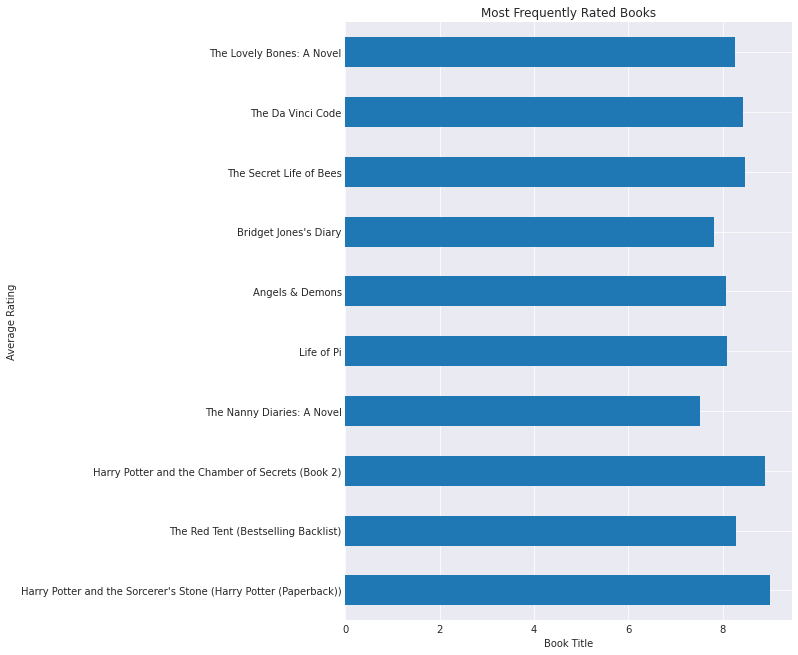

In [8]:
books_with_reviews_and_users['Frequency'] = books_with_reviews_and_users['Book Title'].map(books_with_reviews_and_users['Book Title'].value_counts())
books_by_rating_and_frequency = books_with_reviews_and_users[['Book Title', 'Average Rating', 'Frequency']].groupby('Book Title').mean().sort_values('Frequency', ascending=False).head(10)
plt.style.use('seaborn-darkgrid')
plt.figure()
final_rating_by_frequency = books_by_rating_and_frequency['Average Rating'].plot(kind='barh', figsize=(8,11))
final_rating_by_frequency.invert_yaxis()
plt.title("Most Frequently Rated Books")
plt.xlabel("Book Title")
plt.ylabel("Average Rating");

In [9]:
print(f"As you can see in the bar graph below - just because a book was frequently reviewed and read, doesn't mean it is highly recommended by the community. 'The Lovely Bones' was the most frequently reviewed book with an average rating of: {books_with_reviews_and_users.loc[books_with_reviews_and_users['Book Title'] == 'The Lovely Bones: A Novel']['Average Rating'].max():.2f}")

As you can see in the bar graph below - just because a book was frequently reviewed and read, doesn't mean it is highly recommended by the community. 'The Lovely Bones' was the most frequently reviewed book with an average rating of: 8.25


## Books That Are Frequently Reviewed with High Average Ratings

Therefore, I analyzed next the most frequently reviewed books with the highest ratings.  In the top 10 were books from *Lord of the Rings* series as well as *Harry Potter* series and *To Kill a Mocking Bird*.  If a user is looking for popularity these would be the top 10 books to recommend for all time in our data set.

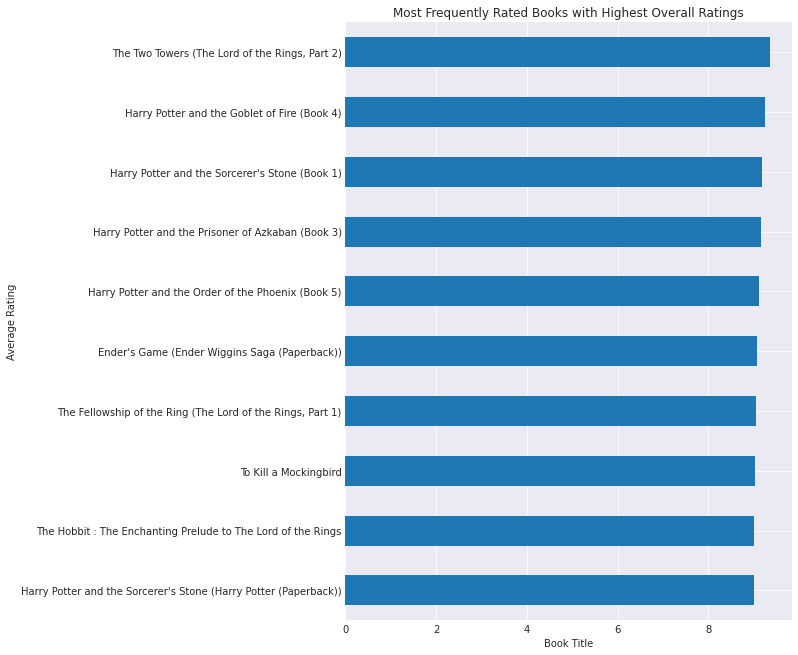

In [10]:
books_by_frequency = books_with_reviews_and_users[['Book Title', 'Book Rating', 'Frequency']].groupby('Book Title').mean().sort_values('Frequency', ascending=False).head(100)
books_by_highest_rated_and_frequency = books_by_frequency.sort_values('Book Rating', ascending=False).head(10)
plt.style.use('seaborn-darkgrid')
plt.figure()
final_highest_rated = books_by_highest_rated_and_frequency['Book Rating'].plot(kind='barh', figsize=(8,11))
final_highest_rated.invert_yaxis()
plt.title("Most Frequently Rated Books with Highest Overall Ratings")
plt.xlabel("Book Title")
plt.ylabel("Average Rating");

## Authors Whose Work is Frequently Read with Wigh Average Ratings

If a user instead was looking for top authors, and then exploring that specific author's work - the bar chart below would be an excellent list based off of ratings to recommend.  Ranging from J.K. Rowling to William Shakespeare - this is the top 10 most commonly read and highest rated list of authors.

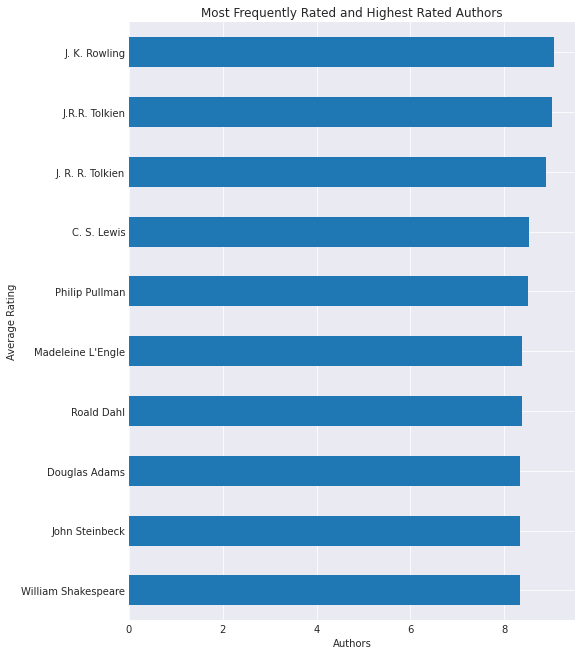

In [11]:
books_with_reviews_and_users['Author Frequency'] = books_with_reviews_and_users['Book Author'].map(books_with_reviews_and_users['Book Author'].value_counts())
books_by_author_frequency = books_with_reviews_and_users[['Book Author', 'Book Rating', 'Author Frequency']].groupby('Book Author').mean().sort_values('Author Frequency', ascending=False).head(100)
books_by_highest_rated_and_author_frequency = books_by_author_frequency.sort_values('Book Rating', ascending=False).head(10)
plt.style.use('seaborn-darkgrid')
plt.figure()
final_highest_rated_authors = books_by_highest_rated_and_author_frequency['Book Rating'].plot(kind='barh', figsize=(8,11))
final_highest_rated_authors.invert_yaxis()
plt.title("Most Frequently Rated and Highest Rated Authors")
plt.xlabel("Authors")
plt.ylabel("Average Rating");

## Books That Are Frequently Read With High Average Ratings by User's Country
#### (Limited to the Top 10 Most Common User's Country)

The above recommendations were more general.  Next I wanted to look more specifically at the user.  Because we couldn't see the specific genre of the books read by specific users, I looked into their location demographics.  From here, I found the top read and rated books from each country.  Now I could create recommendations for a user by finding their country and seeing what book would be best recommend by their countrymates. 

In [12]:
ten_countries = [0,1,2,3,4,5,6,7,8,9]
top_ten_countries = books_with_reviews_and_users['Country'].value_counts().reset_index().head(10)
top_ten_countries.index = top_ten_countries.index.astype(int)
top_ten_countries = top_ten_countries.rename(columns={'index': 'Country', 'Country': 'Count'})

country_book_count_list = books_with_reviews_and_users[['Book Title', 'Country', 'Average Rating', 'Frequency']].groupby(['Book Title', 'Country']).mean().sort_values('Frequency', ascending=False).head(100)
country_book_count_list = country_book_count_list.sort_values(['Average Rating', 'Frequency'], ascending=False)
country_book_count_list = country_book_count_list.reset_index().rename(columns = {0: 'Book Read by Country Frequency'})
top_book_per_country = country_book_count_list.groupby('Country').head(1)

country_book_list = top_book_per_country.merge(top_ten_countries, how='inner').sort_values(['Count'], ascending=False)      
country_book_list[['Country', 'Book Title']].style.hide_index()

Country,Book Title
Usa,The Secret Life of Bees
Canada,The Secret Life of Bees
United Kingdom,The Secret Life of Bees
Germany,The Secret Life of Bees
Spain,The Secret Life of Bees
Australia,The Da Vinci Code
France,The Secret Life of Bees
Portugal,The Da Vinci Code
Malaysia,The Secret Life of Bees
Switzerland,The Lovely Bones: A Novel


## Books Most Frequently Read With High Average Ratings By User's Age

Then I took the analysis further and more specific for the users I have compiled. Although most read book in a country might satisfy a lot of readers it is still pulling from a broad group.  So, I looked more specifically at the age of each reader and what book is most commonly read among peers. Below is for the age range of 5 to 54 for book recommendations.

In [13]:
age_book_count_list = books_with_reviews_and_users.value_counts(['Age', 'Book Title', 'Average Rating']).to_frame().reset_index().rename(columns = {0: 'Book Read by Age Frequency'})
age_book_count_list = age_book_count_list.sort_values(['Book Read by Age Frequency', 'Average Rating'], ascending=False)
top_book_per_age = age_book_count_list.groupby('Age').head(1)
df_no_indices = top_book_per_age[['Age', 'Book Title']].sort_values('Age', ascending=True).head(50)
df_no_indices.Age = df_no_indices.Age.astype(int)
df_no_indices.style.hide_index()

Age,Book Title
5,Fairy Things to Make and Do (Activity Books)
6,How to Eat Fried Worms
7,"Scooby-Doo and the Haunted Castle (Scooby-Doo Mysteries, 1)"
8,The Cat in the Hat
9,Captain Underpants and the Attack of the Talking Toilets: Another Epic Novel (Captain Underpants (Paper))
10,Captain Underpants and the Wrath of the Wicked Wedgie Woman
11,Inuyasha (Inuyasha)
12,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
13,Harry Potter and the Chamber of Secrets (Book 2)
14,Harry Potter and the Prisoner of Azkaban (Book 3)


## Most Frequently Book With High Average Ratings By Age & Country

Even more specifically, I looked into the analysis of the most read books by user's age and country.  I then created a recommendation list based off of those two specific factors.

In [14]:
country_book_age_count_list = books_with_reviews_and_users.value_counts(['Country', 'Age', 'Book Title', 'Average Rating']).to_frame().reset_index().rename(columns = {0: 'Book Read by Country Frequency'})
country_book_age_count_list = country_book_age_count_list.sort_values(['Book Read by Country Frequency', 'Average Rating'], ascending=False)
top_book_per_country_per_age = country_book_age_count_list.groupby(['Country', 'Age']).head(1)
country_book_list_per_age = top_book_per_country_per_age[['Country', 'Age', 'Book Title']].head(25)
country_book_list_per_age.Age = country_book_list_per_age.Age.astype(int)
country_book_list_per_age.sort_values('Age', ascending=True).style.hide_index()

Country,Age,Book Title
Usa,17,Coal: A Human History
Usa,18,Simisola
Usa,19,The Catcher in the Rye
Usa,23,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Usa,24,Harry Potter and the Chamber of Secrets (Book 2)
Usa,25,The Lovely Bones: A Novel
Usa,26,The Da Vinci Code
Usa,27,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Usa,28,The Lovely Bones: A Novel
Usa,29,The Da Vinci Code


<a id="section-four"></a>
# Conclusion

There are many ways to recommend a book to another reader - whether it is by personal preference or using a data analysis.  I was only able to make an initial dive into the data by providing what you would recommend to someone looking for the most popular book overall in the data set, most popular book by their country, most popular book by their age, and most popular book by their age and country.

For example, if you were to recommend a book to me - I am 25 from the USA.  Here are my results:
1. By Overall High Ranking and Popularity of Books: The Two Towers (Lord of the Rings)
2. By Overall Ranking and Popularity of Authors: J.K. Rowling
3. By Country Most Popular Book: The Secret Life of Bees
4. By Age Most Popular Book for 25 Year Olds: The Lovely Bones: A Novel
5. By Age and Country Most Popular: The Lovely Bones: A Novel


It is clear that this data set is dynamic, ever updating, and not complete.  More analysis would be required to truly give a proper recommendation system.  But it is a start.  It was interesting to explore this data set and what it could do bringing the 3 csvs together.  Also basing my analysis off of popularity, I was able to be some preliminary validation in that Lord of the Rings and Harry Potter series books were the most popular.  Moving forward more validation would need to be completed to use this data.  But it was certainly an interesting start!

## Going Forward
My next steps would be to create a functionality to the analysis where a user could input their data, and it would give back recommendations based on the five lists I created.